In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week,\
forecast_by_week, train_test_split,update_deepAR_parameters, hyperparameter_boxplots,\
generate_model_results_by_hp_dict, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
import itertools
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

config.train_start_time = datetime(1999,1,1,0,0,0)#datetime(2010,1,1,0,0,0)
config.train_end_time = datetime(2016,9,30,23,0,0)
config.test_end_time = datetime(2018,9,30,23,0,0)
data_splits_dict = {}

locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
df = preprocessing(config, df, check_count=False, output_type="corrected_df")
for location in locations:
    df.loc[df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    df.loc[df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0].astype(int)
data_splits_dict["with_features_2001"] = list(train_test_split(config, df, True))
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


In [2]:
default_fnn_estimator = SimpleFeedForwardEstimator(num_hidden_dimensions=None, prediction_length=4, context_length=None,
                                                  distr_output=config.fnnparameters["distr_output"], batch_size=32,
                                                  batch_normalization=False, trainer=Trainer(epochs=100,num_batches_per_epoch=50)
                                                  )
default_deepar_estimator = DeepAREstimator(freq=config.parameters["freq"],
                        context_length=4,
                        prediction_length=4,
                        num_layers=2,
                        num_cells=40,
                        cell_type="lstm",
                        trainer=Trainer(epochs=100),
                        distr_output=config.parameters["distr_output"],
                        use_feat_static_real=False,
                        use_feat_static_cat=False,
                        use_feat_dynamic_real=False)

In [3]:
estimators = {"DeepAR":default_deepar_estimator, "FNN":default_fnn_estimator}
results_dict = {}
for key in estimators.keys():
    predictor = estimators[key].train(train)
    forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor,num_samples=100)
    results_dict[f"{key}_forecasts"] = list(forecast_it)
    results_dict[f"{key}_tss"] = list(ts_it)

100%|██████████| 50/50 [00:31<00:00,  1.58it/s, epoch=100/100, avg_epoch_loss=0.797]


In [5]:
print(results_dict.keys())

dict_keys(['DeepAR_forecasts', 'DeepAR_tss', 'FNN_forecasts', 'FNN_tss'])


In [10]:
for model in ["DeepAR", "FNN"]:
    # Evaluation with the quantiles of the configuration and calculation of the mean_WIS
    evaluator = Evaluator(quantiles=config.quantiles)    
    agg_metrics = evaluator(results_dict[f"{model}_tss"], results_dict[f"{model}_forecasts"])[0]
    mean_WIS = agg_metrics["mean_absolute_QuantileLoss"]/(4*411)
    print(f"{model} mean WIS: {mean_WIS}")

Running evaluation: 41922it [00:03, 12952.14it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


DeepAR mean WIS: 399.9312521724018


Running evaluation: 41922it [00:02, 14884.34it/s]


FNN mean WIS: 594.3899678484534


/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [137]:
print(agg_metrics)

{'MSE': 4108.672015748734, 'abs_error': 1273681.0, 'abs_target_sum': 1882993.0, 'abs_target_mean': 11.22914579457087, 'seasonal_error': 1.263216516902224, 'MASE': 5.827377078564039, 'MAPE': 1.0631934450093508, 'sMAPE': 1.418378942307302, 'MSIS': 96.0288950968666, 'QuantileLoss[0.025]': 90637.85000000002, 'Coverage[0.025]': 0.00016697676637565003, 'QuantileLoss[0.1]': 340117.0, 'Coverage[0.1]': 0.00178903678259625, 'QuantileLoss[0.25]': 753023.5, 'Coverage[0.25]': 0.015427460521921664, 'QuantileLoss[0.5]': 1273681.0, 'Coverage[0.5]': 0.09839105958685178, 'QuantileLoss[0.75]': 1680289.5, 'Coverage[0.75]': 0.34874290348742903, 'QuantileLoss[0.9]': 1675277.3999999997, 'Coverage[0.9]': 0.6805674824674395, 'QuantileLoss[0.975]': 1027213.5000000009, 'Coverage[0.975]': 0.8560839177520156, 'RMSE': 64.09892367075078, 'NRMSE': 5.708263553024815, 'ND': 0.6764130296820009, 'wQuantileLoss[0.025]': 0.04813499041154164, 'wQuantileLoss[0.1]': 0.18062573785457514, 'wQuantileLoss[0.25]': 0.39990775324178

In [17]:
forecasts_dict = {}
for model in ["DeepAR", "FNN"]:
    split_tss = split_forecasts_by_week(config, results_dict[f"{model}_forecasts"], results_dict[f"{model}_tss"], locations, 4, equal_time_frame=True)[1]
    forecast_dict ={1 : split_forecasts_by_week(config, results_dict[f"{model}_forecasts"], results_dict[f"{model}_tss"], locations, 1, equal_time_frame=True)[0],
                    2 : split_forecasts_by_week(config, results_dict[f"{model}_forecasts"], results_dict[f"{model}_tss"], locations, 2, equal_time_frame=True)[0],
                    3 : split_forecasts_by_week(config, results_dict[f"{model}_forecasts"], results_dict[f"{model}_tss"], locations, 3, equal_time_frame=True)[0],
                    4 : split_forecasts_by_week(config, results_dict[f"{model}_forecasts"], results_dict[f"{model}_tss"], locations, 4, equal_time_frame=True)[0]}
    forecasts_dict[model]=forecast_dict

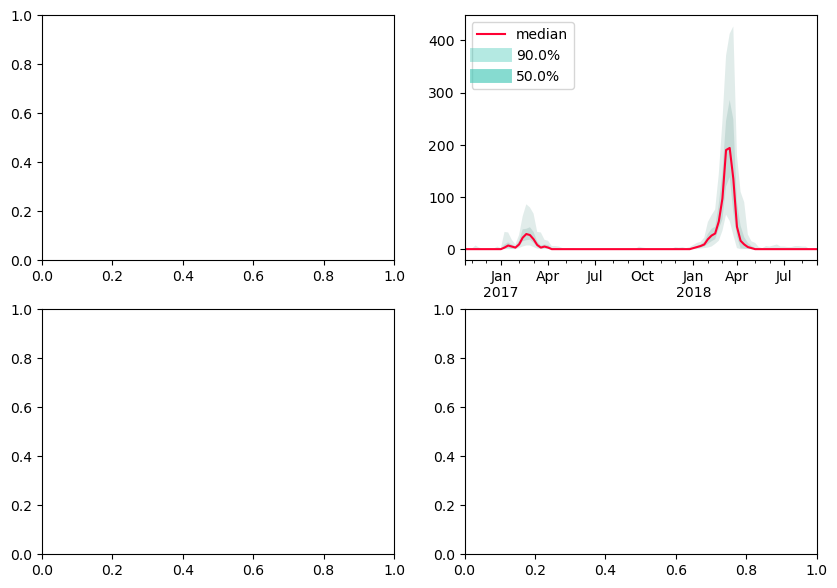

In [134]:
def pf(config, fe, show_mean=False,ax=plt, prediction_intervals=(50.0, 90.0), meancolor=config.colors[1], mediancolor=config.colors[0], fillcolor=config.colors[4]):
    '''
    Overwritten version of the forecast_entry.plot() method.
    Includes customizable colors and axis.
    '''
    # Determining the Prediction Intervals alpha levels for plotting
    for c in prediction_intervals:
        assert 0.0 <= c <= 100.0

    ps = [50.0] + [
        50.0 + f * c / 2.0
        for c in prediction_intervals
        for f in [-1.0, +1.0]
    ]
    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    ps_data = [fe.quantile(p / 100.0) for p in percentiles_sorted]
    i_p50 = len(percentiles_sorted) // 2
    # Plotting the Median of the forecast entry
    p50_data = ps_data[i_p50]
    p50_series = pd.Series(data=p50_data, index=fe.index)
    plt.sca(ax)
    p50_series.plot(color=mediancolor, ls="-", label="median")
    
    # Plotting the mean of the forecast entry
    if show_mean:
        mean_data = np.mean(fe._sorted_samples, axis=0)
        pd.Series(data=mean_data, index=fe.index).plot(
            color=meancolor,
            ls=":",
            label=f"mean",
        )
    # Plotting the 
    for i in range(len(percentiles_sorted) // 2):
        ptile = percentiles_sorted[i]
        alpha = alpha_for_percentile(ptile)
        plt.fill_between(
            fe.index,
            ps_data[i],
            ps_data[-i - 1],
            facecolor=fillcolor,
            alpha=alpha,
            interpolate=True
        )
        # Hack to create labels for the error intervals. Doesn't actually
        # plot anything, because we only pass a single data point
        pd.Series(data=p50_data[:1], index=fe.index[:1]).plot(
            color=config.colors[2],
            alpha=alpha,
            linewidth=10,
            label=f"{100 - ptile * 2}%",
        )
        
fe = forecast_dict[list(forecasts_dict["DeepAR"].keys())[1-1]][locations.index(location)]

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
pf(config, fe, show_mean=False, meancolor=config.colors[1],ax=ax[(0,1)], mediancolor=config.colors[1],fillcolor=config.colors[4])
plt.legend(loc="upper left")
plt.show()

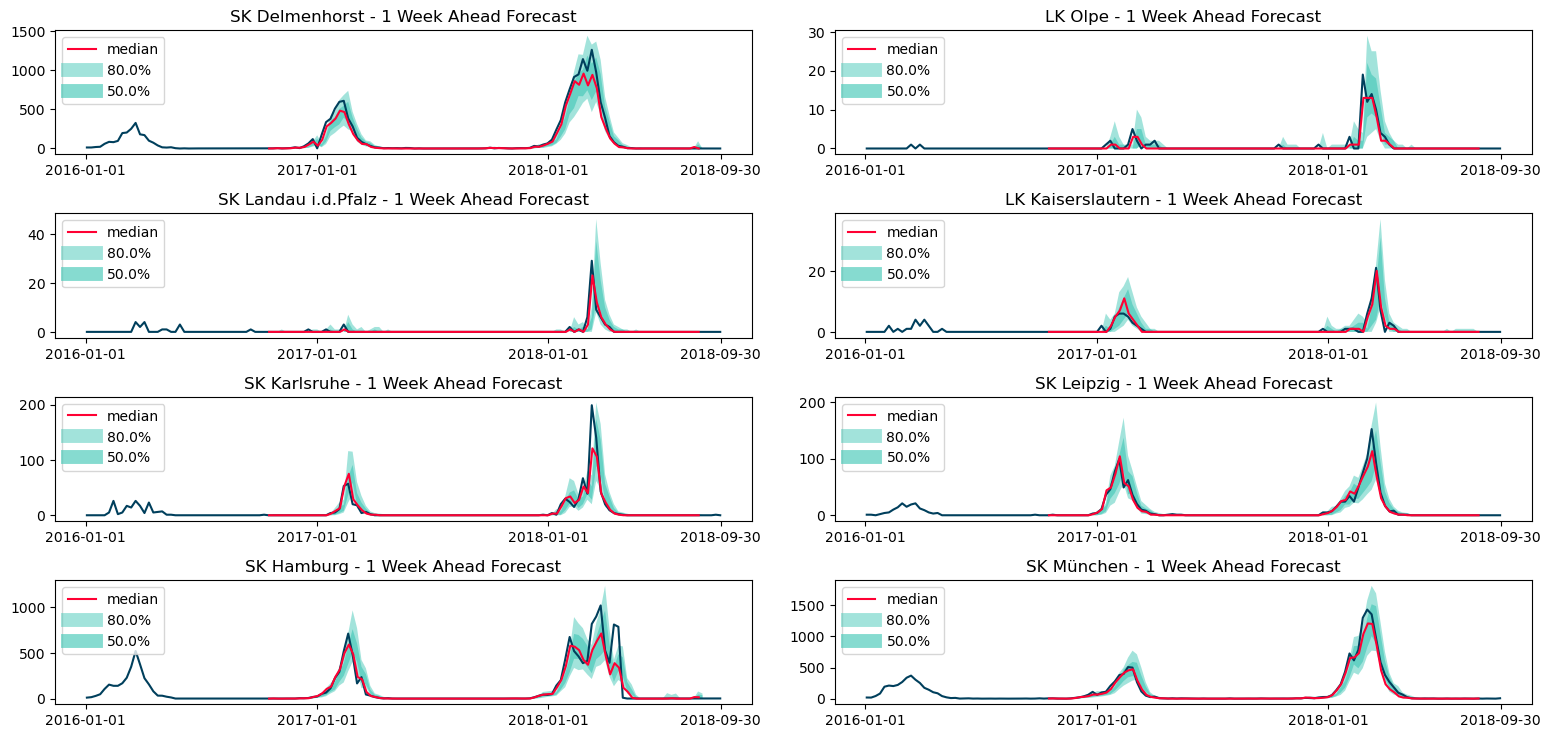

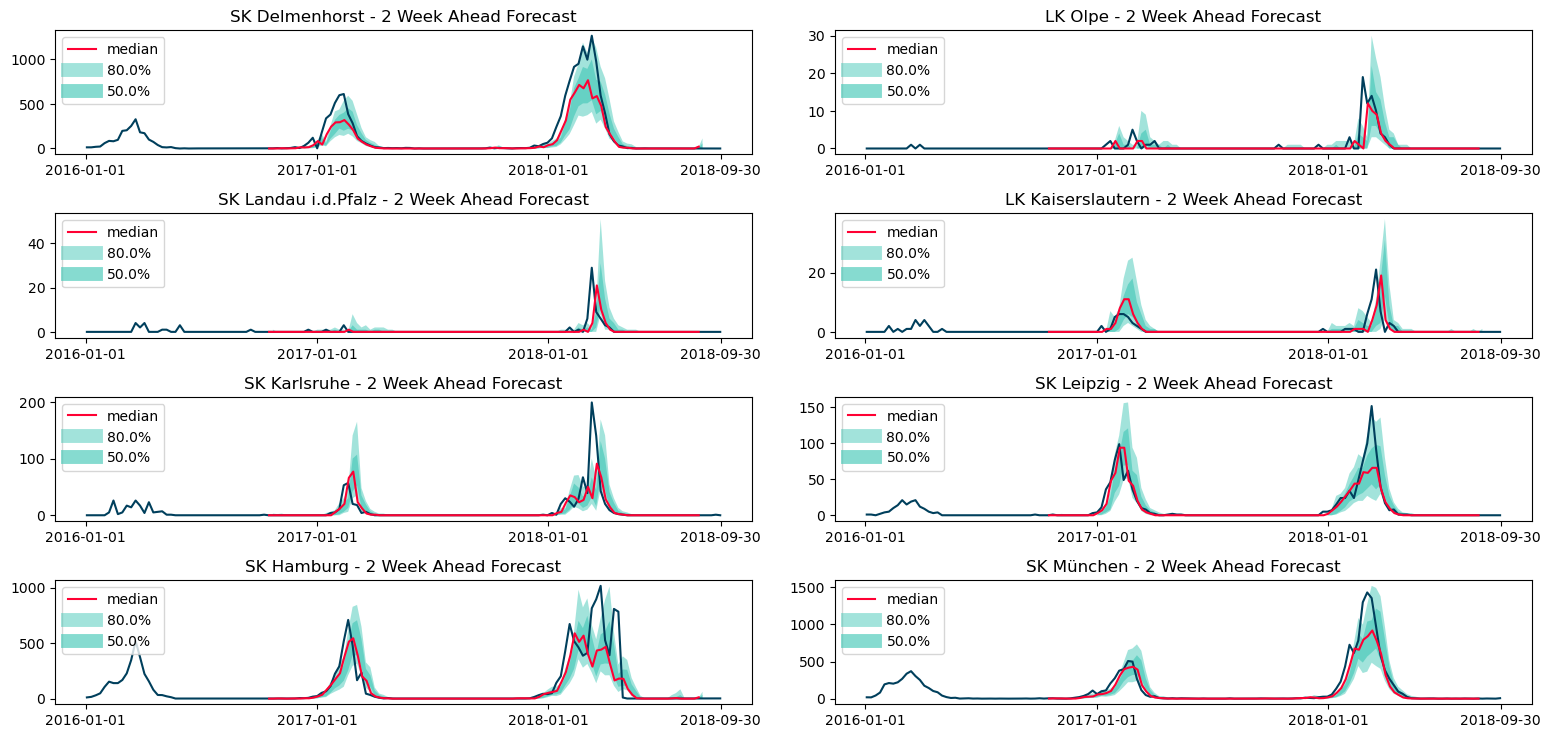

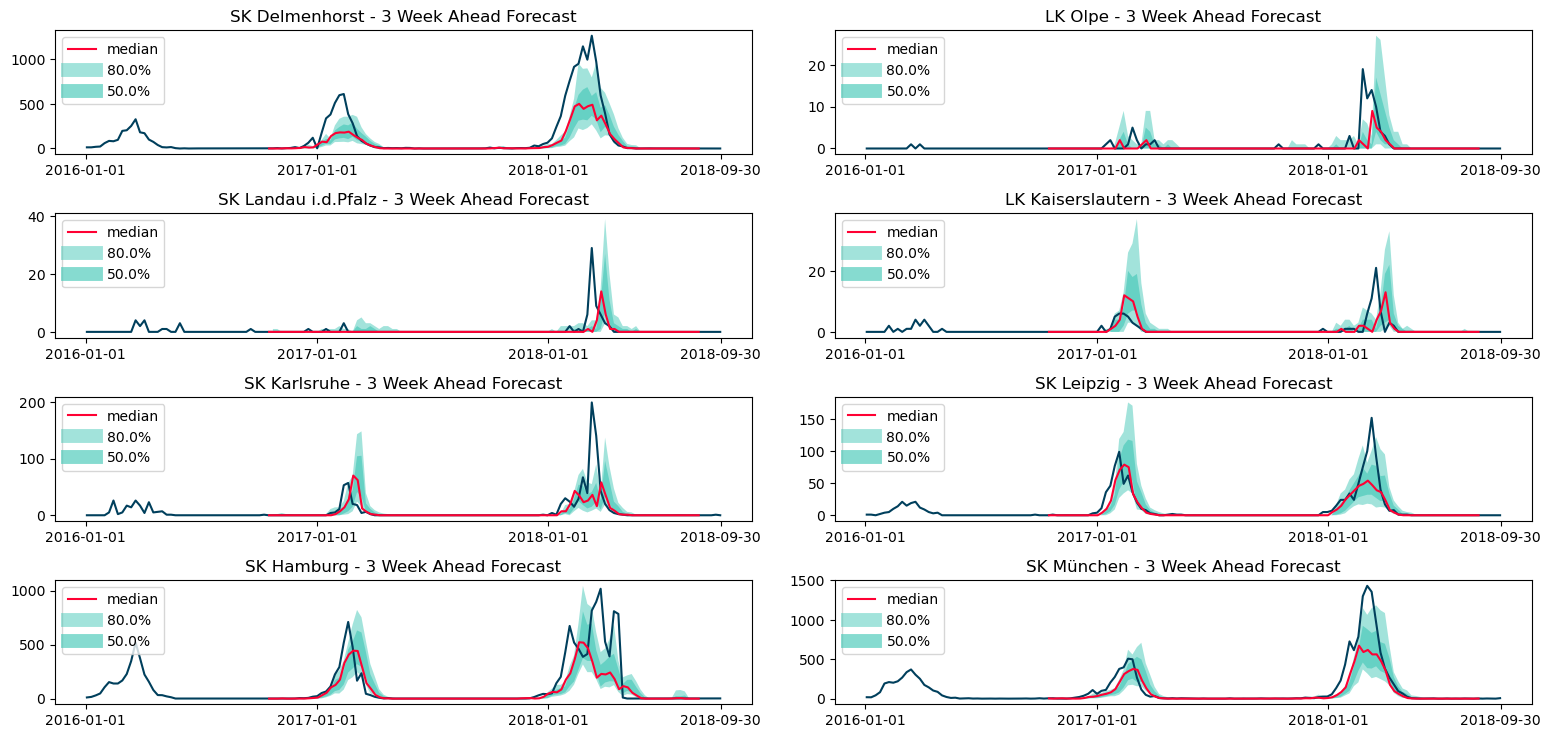

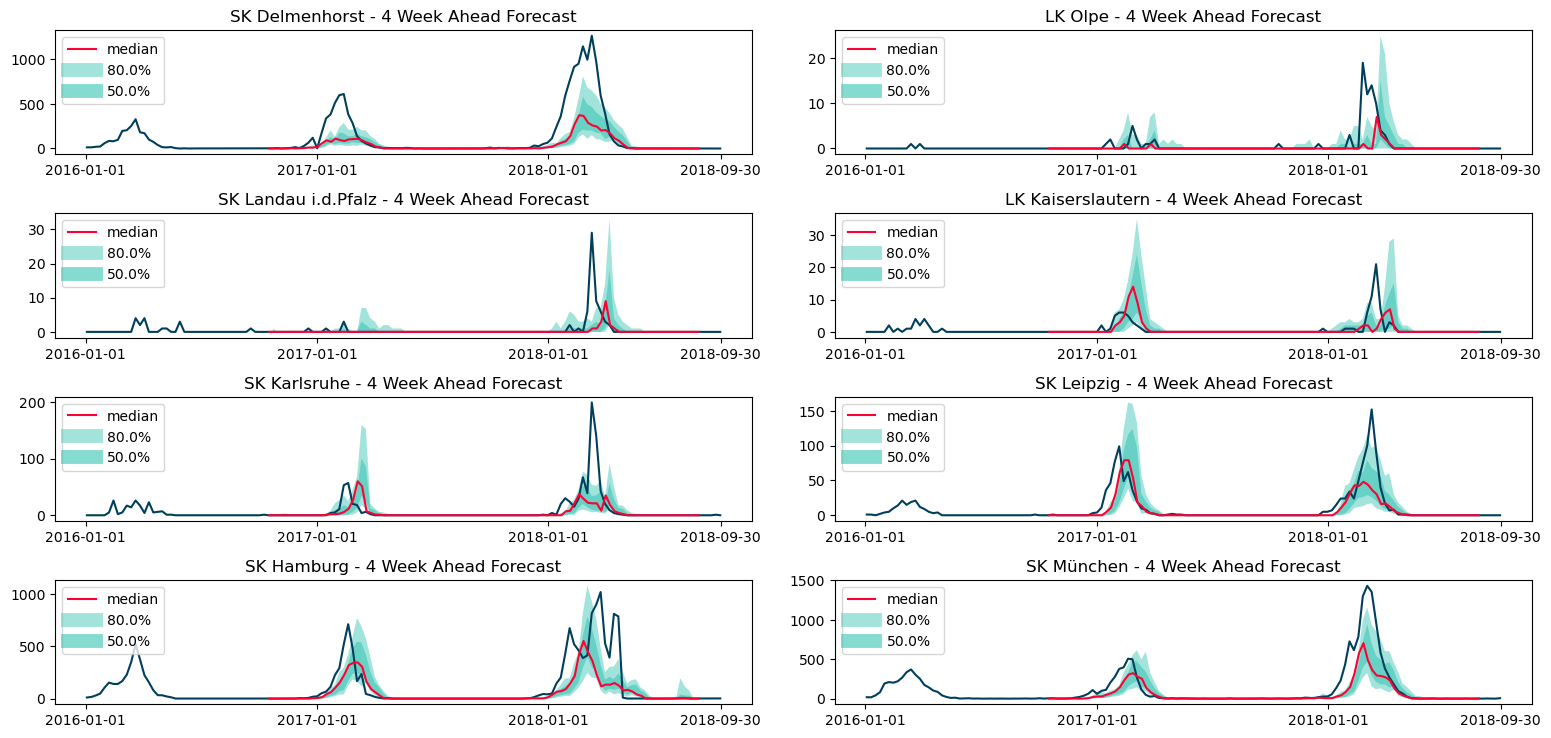

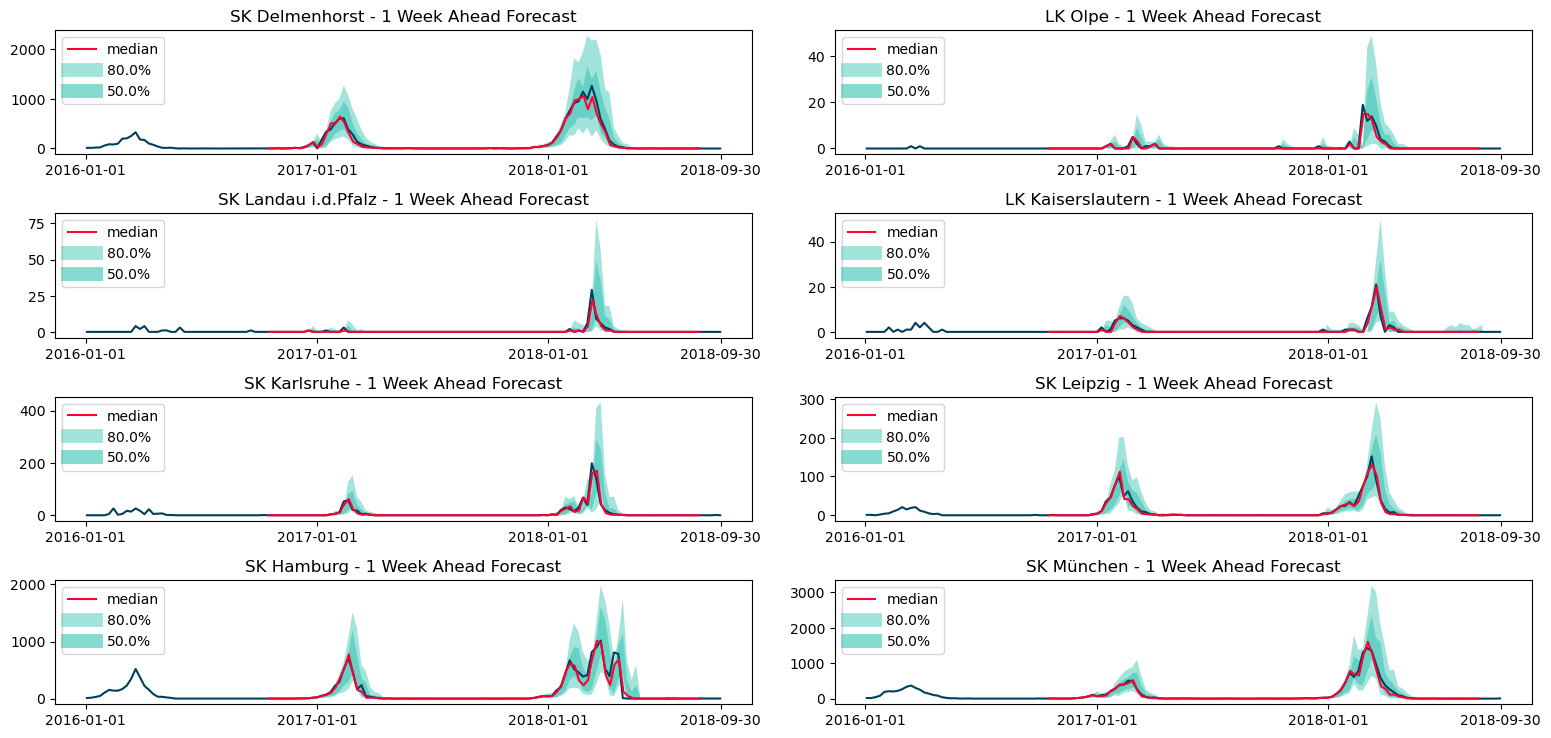

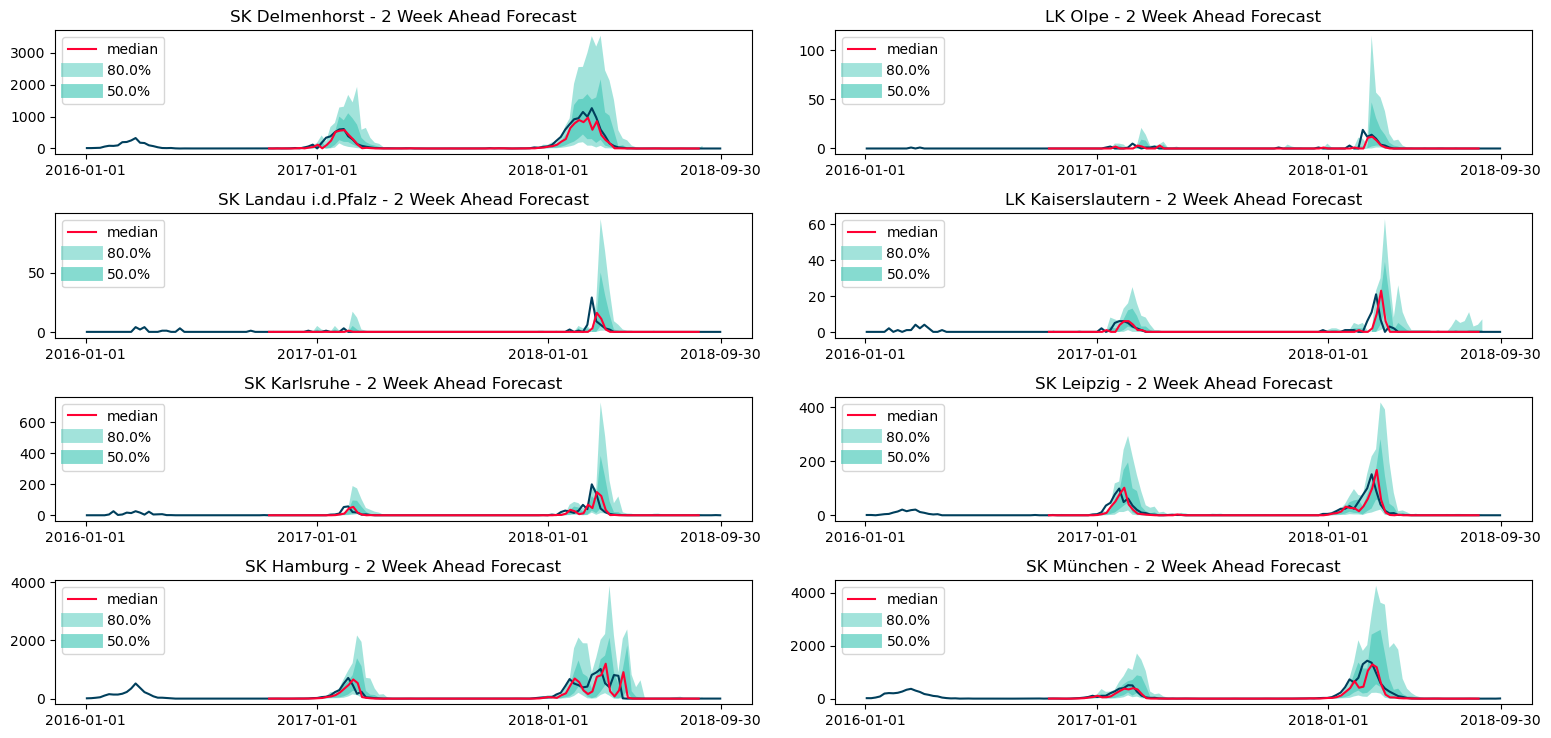

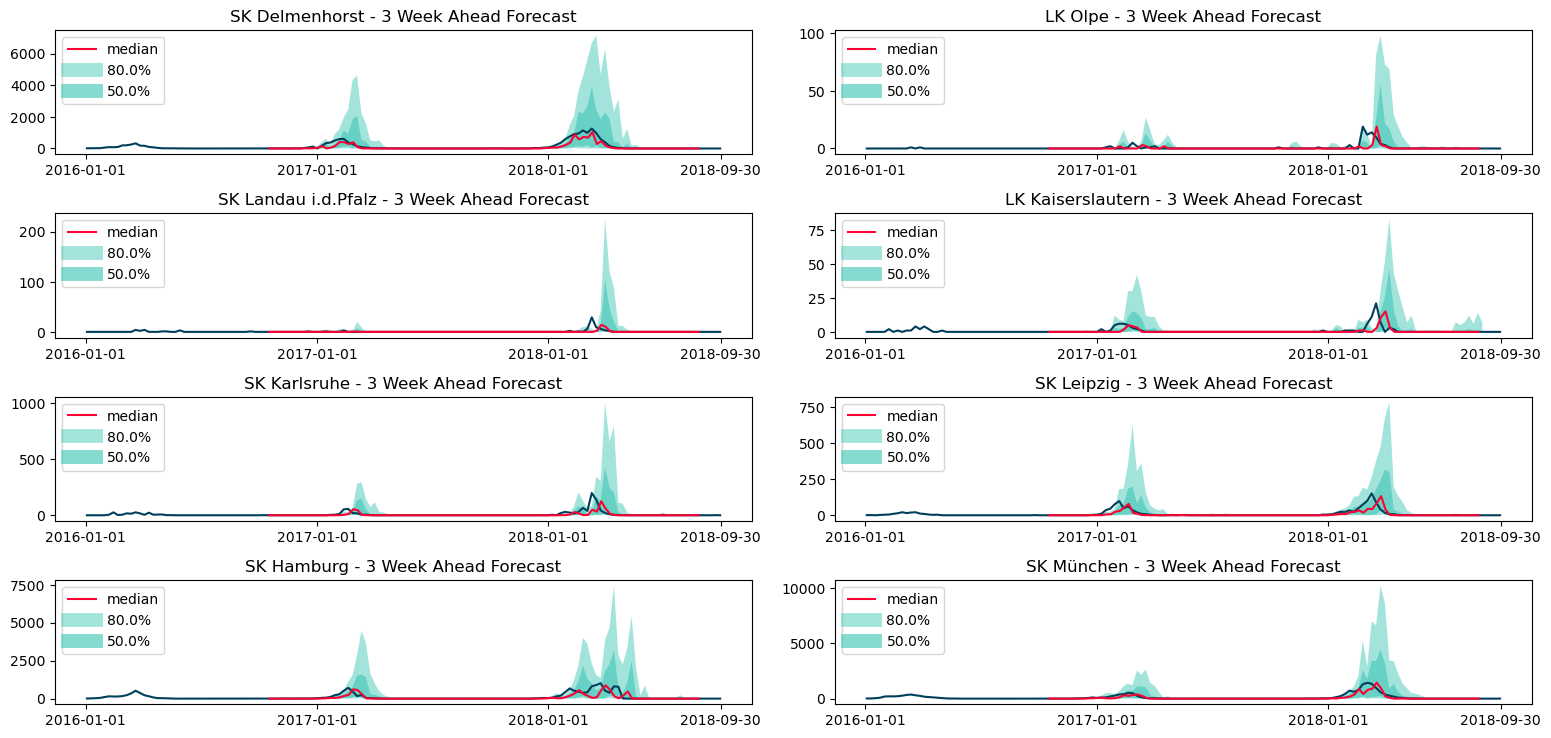

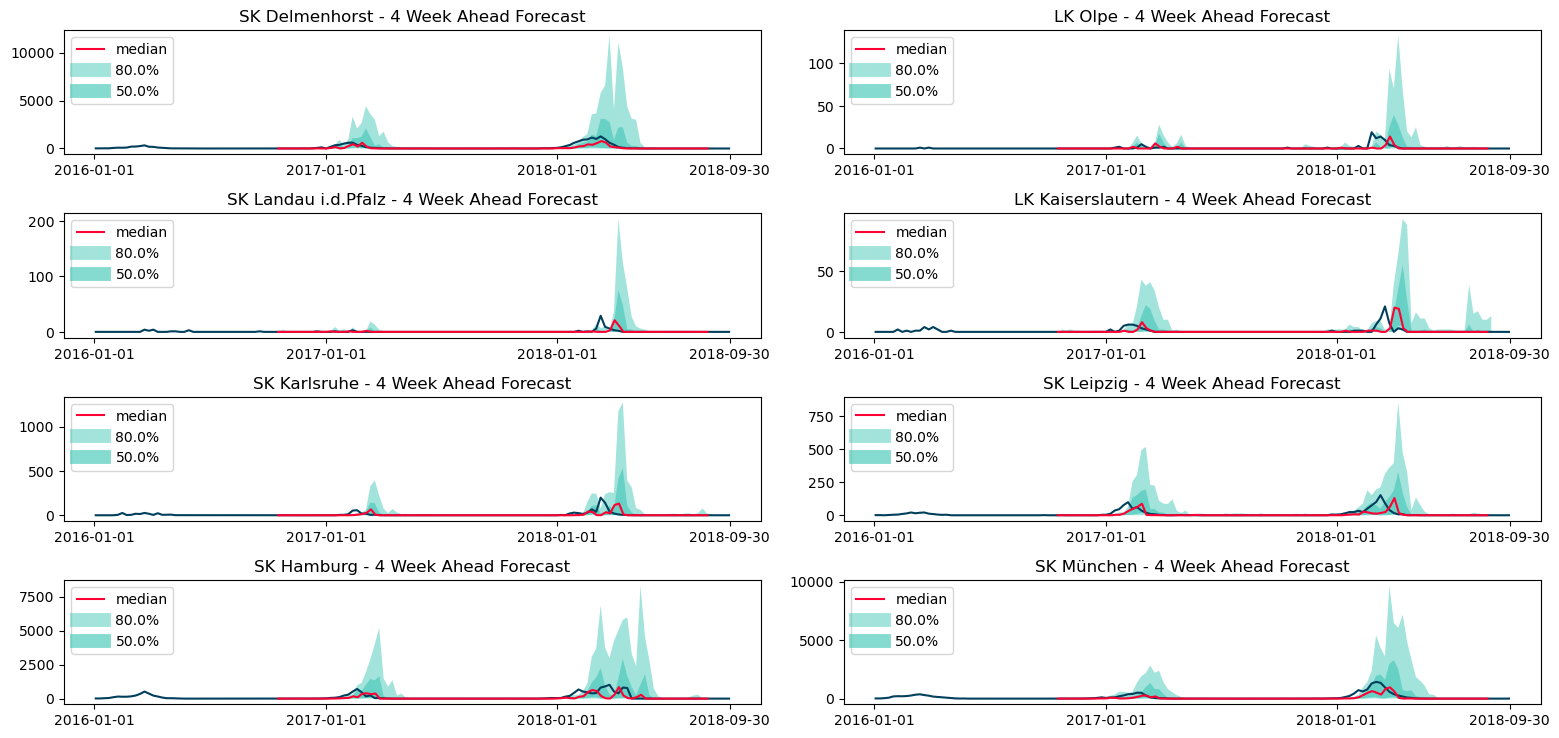

In [136]:
def print_forecasts_by_week_1(config, df, forecasts_dict, locations, week_ahead_list, plot_begin_at_trainstart=False):
    '''
    Prints out plots for the given week-Ahead forecasts of given locations. It needs the initial corrected dataframe, as well as the forecast_dict
    that contains the different week-ahead forecasts.
    The start of the plot time axis, can be set to the training start time (TRUE) or the testing start time (FALSE).
    '''
    
    all_locations=list(df.location.unique())
    for key in list(forecasts_dict.keys()):
        forecast_dict = forecasts_dict[key]
        for week_ahead in week_ahead_list:
            nrows = int(len(locations)/2) + int(len(locations)%2)
            fig, ax = plt.subplots(nrows, 2, figsize=(16, 9))
            fig.tight_layout(pad=2.9)
            plotnumber = [0, 0]
            for location in locations:
                if list(locations).index(location)%2 == 1:
                    plotnumber[1] = 1
                else:
                    if list(locations).index(location) > 1:
                        plotnumber[0] += 1
                    plotnumber[1] = 0
                #plot the forecasts
                plt.title(f'{location} - {week_ahead} Week Ahead Forecast')
                plt.xticks(rotation=0)
                # determine the beginning of the time series
                if plot_begin_at_trainstart == True:
                    plot_start_time = config.train_start_time
                elif type(plot_begin_at_trainstart)==type(datetime(2016,1,1,1,1,1)):
                    plot_start_time = plot_begin_at_trainstart
                else:
                    plot_start_time = config.train_end_time
                #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
                ax[tuple(plotnumber)].plot((df.loc[(df['location'] == location) &
                                        (df.index <= config.test_end_time) &
                                        (df.index >= plot_start_time)].index),
                         df.loc[(df['location'] == location) &
                                       (df.index <= config.test_end_time) &
                                       (df.index >= plot_start_time),'value'], c=config.colors[0])
                #ax[tuple(plotnumber)].grid(which="both")

                # select the right week-ahead forecast entry for a set location
                forecast_entry = forecast_dict[list(forecast_dict.keys())[week_ahead-1]][all_locations.index(location)]
                # run the overwritten version of the forecast_entry.plot() function to plot to a specific axis and change colors
                pf(config, forecast_entry, ax=ax[tuple(plotnumber)],mediancolor=config.colors[1], fillcolor=config.colors[2], prediction_intervals=(50.0, 80.0))
                #forecast_entry.plot(prediction_intervals=prediction_intervals, color=config.colors[0])
                plt.xticks([plot_start_time, datetime(2017,1,1), datetime(2018,1,1), config.test_end_time], rotation=0, ha="center")
                plt.legend(loc="upper left")
            os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
            plt.savefig(f"Default{key}{week_ahead}_WA.png")
            plt.show()
            os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
selected_regions = ['SK München','SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg']

print_forecasts_by_week_1(config, df, forecasts_dict, selected_regions, [1,2,3,4], plot_begin_at_trainstart=datetime(2016,1,1,0,0,0))